In [238]:
from MNIST_dataloader import Noisy_MNIST
from Fast_MRI_dataloader import Fast_MRI
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torch.utils.data import TensorDataset
import glob
import numpy as np
from tqdm import tqdm 
from PIL import Image
import torchvision

In [239]:
# Bram
data_loc = 'D://5LSL0-Datasets' #change the datalocation to something that works for you
# Bram laptop
# data_loc = 'C://Users//domin//Desktop//5LSL0'
#Amin
# data_loc = 'C://Gebruikers/amin2/Documenten/School/5LSL0 - MLSignal/5LSL0/data'

In [240]:
# %% dataloader for the Noisy MNIST dataset
def create_dataloaders_noisy_mnist(data_loc, batch_size):
    Noisy_MNIST_train = Noisy_MNIST("train", data_loc)
    Noisy_MNIST_test  = Noisy_MNIST("test" , data_loc)
    
    Noisy_MNIST_train_loader =  DataLoader(Noisy_MNIST_train, batch_size=batch_size, shuffle=True,  drop_last=False)
    Noisy_MNIST_test_loader  =  DataLoader(Noisy_MNIST_test , batch_size=batch_size, shuffle=False, drop_last=False)
    
    return Noisy_MNIST_train_loader, Noisy_MNIST_test_loader

In [241]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [244]:
def shrinkage(x, thresholds):
    return x + 0.5 * (torch.sqrt((x - thresholds) ** 2 + 1) - torch.sqrt((x + thresholds) ** 2 + 1))

In [245]:
class LISTA(nn.Module):
    def __init__(self):
        super(LISTA, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1)
        self.thresholds = nn.Parameter(torch.ones(3))  # Layer-dependent thresholds
        self.lambdas = nn.Parameter(torch.ones(3))  # Layer-dependent shrinkage parameters

    def forward(self, input, num_unfolds):
        out = input
        for _ in range(num_unfolds):
            out = shrinkage(out, self.thresholds[_])
            out = self.conv1(out)
            out = shrinkage(out, self.thresholds[_])
            out = self.conv2(out)
        return out

In [246]:
model = LISTA()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [247]:
# get dataloader
batch_size = 32
train_loader, test_loader = create_dataloaders_noisy_mnist(data_loc, batch_size)

# get some examples
training_set = enumerate(train_loader)
_, (x_clean, x_noisy, labels) = next(training_set)

noisy_image = x_noisy
gt_image = x_clean

In [ ]:
# Model/training constants
num_epochs = 10
num_unfolds = 3

Epoch [1/10], Loss: 0.2647349032402039
Epoch [2/10], Loss: 0.027675343423088392
Epoch [3/10], Loss: 0.020132636070251463
Epoch [4/10], Loss: 0.018437384475270907
Epoch [5/10], Loss: 0.017813931932051975
Epoch [6/10], Loss: 0.017626076232890288
Epoch [7/10], Loss: 0.017574274006485938
Epoch [8/10], Loss: 0.01755896589209636
Epoch [9/10], Loss: 0.017546584179500738
Epoch [10/10], Loss: 0.017544382804632188


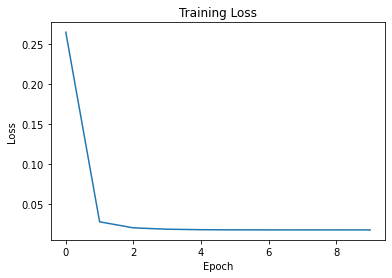

In [248]:
# Training loop
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for (_, (x_clean, x_noisy, labels)) in enumerate(train_loader):  # Modify here
        optimizer.zero_grad()
        outputs = model(x_noisy,num_unfolds)  # Assuming x_noisy is the input to the model
        loss = loss_function(outputs, x_clean)  # Assuming x_clean is the target
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [249]:
# Pass the input batch through the LISTA model
output_denoised = model(noisy_image,num_unfolds)

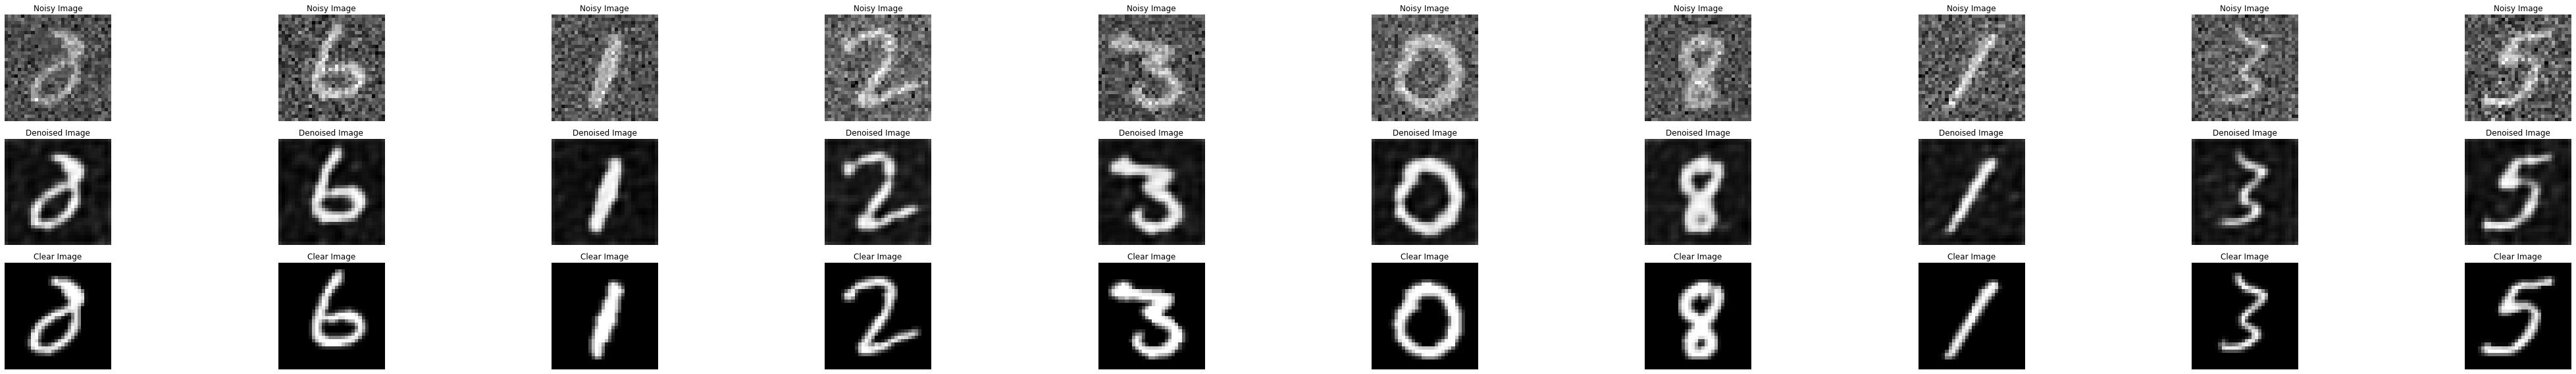

In [286]:
# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(6 * 10, 8))

for i in range(10):
#    # Get the clear image and denoised image for the current iteration
     # denoised_image_np = denoised_images
     # clear_image_np = input_images

#    # Plot the denoised image in the first row of subplots
     axes[0, i].imshow(noisy_image[i].squeeze(), cmap='gray')
     axes[0, i].set_title('Noisy Image')
     axes[0, i].axis('off')  

#     # Plot the denoised image in the first row of subplots
     axes[1, i].imshow(output_denoised[i].squeeze(0).detach().numpy(), cmap='gray')
     axes[1, i].set_title('Denoised Image')
     axes[1, i].axis('off')  

#     # Plot the clear image in the second row of subplots
     axes[2, i].imshow(gt_image.squeeze()[i,:,:], cmap='gray')
     axes[2, i].set_title('Clear Image')
     axes[2, i].axis('off')


# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [287]:
count = 0
avg_mse = 0

for i in range(len(denoised_images)):
    y = gt_image.squeeze()[i,:,:].numpy()
    y_pred = output_denoised[i].squeeze(0).detach().numpy()
    mse = np.mean((y - y_pred)**2)
    count +=1
    avg_mse += mse
avg_mse /=count
print(avg_mse)

0.01671980184619315


In [ ]:
# for epoch in range(num_epochs):
#     running_loss = 0.0
#     for i in range(len(noisy_image)):
#         inputs = noisy_image[i]
#         labels = gt_image[i]
#         optimizer.zero_grad()
#         outputs = model(inputs, num_unfolds)
#         loss = loss_function(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     epoch_loss = running_loss / len(train_loader)
#     losses.append(epoch_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")
